In [1]:
import pandas as pd

In [57]:
data = pd.read_csv('data/AusAntidiabeticDrug.csv', index_col='ds')
data = data.set_index(pd.DatetimeIndex(data.index))
data.head(12)

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
1991-12-01,4.306371
1992-01-01,5.088335
1992-02-01,2.814520
1992-03-01,2.985811


In [42]:
m = 12 # data is monthly, equivalent to s

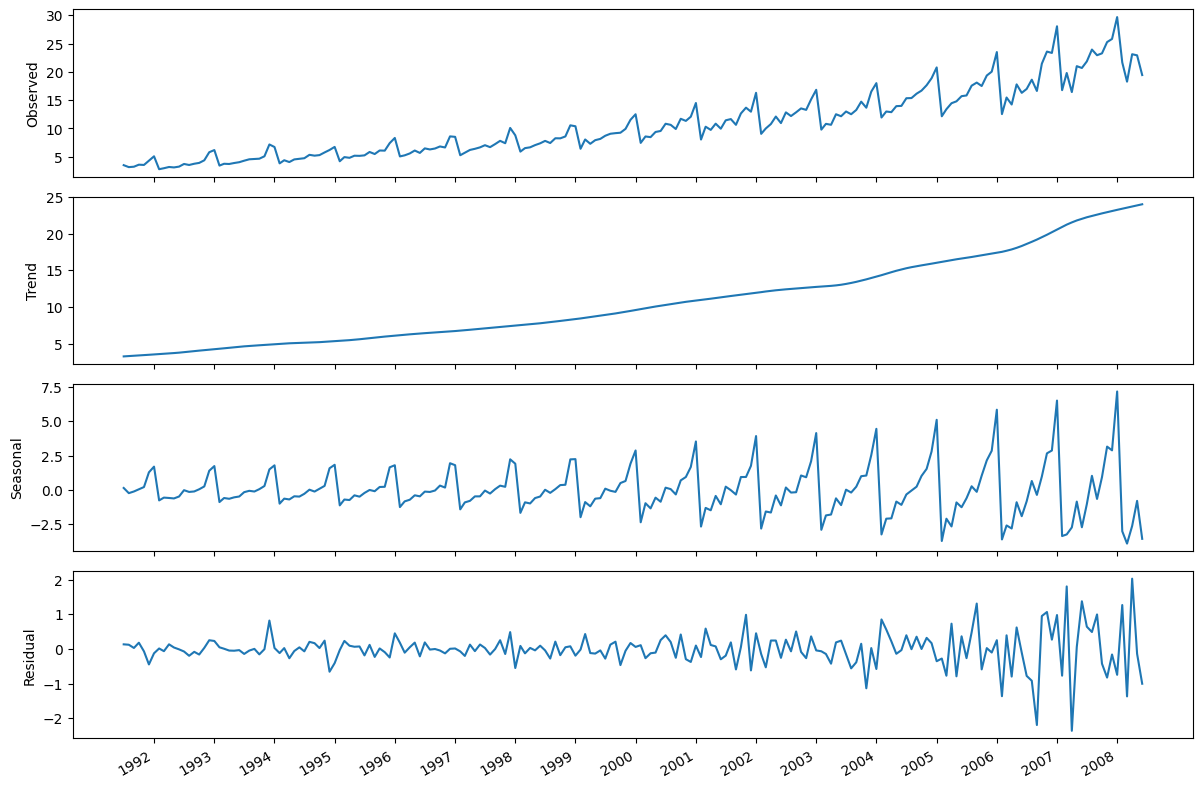

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import STL

d = STL(data['y'], period=m).fit()

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12,8))
axs: list[Axes]

for i, (decomp_series, label) in enumerate(zip([d.observed, d.trend, d.seasonal, d.resid], 
                                               ['Observed', 'Trend', 'Seasonal', 'Residual'])):
    axs[i].plot(data.index, decomp_series)
    axs[i].set_ylabel(label)

FROM = 6
EVERY = 12
plt.xticks(data.index[FROM::EVERY], data.index.year[FROM::EVERY])

fig.autofmt_xdate()
fig.tight_layout()

A $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model is optimal because (a) there are no exogenous variables (no X) (b) there is clear seasonality and (c) we only wish to predict one target, so VAR is not necessary.

In [33]:
from typing import Union
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: Union[pd.Series, np.ndarray]):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')

In [50]:
test_stationarity(data['y'])

y_diff = data['y'].diff().iloc[1:]

test_stationarity(y_diff)

test_stationarity(np.diff(y_diff, m))

ADF Statistic: 3.145
p-value: 1.000
ADF Statistic: -2.495
p-value: 0.117
ADF Statistic: -19.848
p-value: 0.000


Our final model will be a $\text{SARIMA}(p,1,q)(P,1,Q)_{12}$ model.

In [75]:
# important to specify 'y' here, otherwise the index will be used
train = data['y'].iloc[:168]
test = data['y'].iloc[168:]

assert len(train) % m == 0
assert len(test) % m == 0

In [73]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

In [68]:
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

pqPQ = tuple[int, int, int, int]

def optimize_SARIMA(
    endog: Union[pd.Series, list], 
    order_list: list[pqPQ],
    d: int,
    D: int,
    s: int,
) -> pd.DataFrame:
    results: list[tuple(pqPQ, np.float64)] = []
    for order in tqdm(order_list):
        p, q, P, Q = order
        try:
            model = SARIMAX(
                endog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue 
        aic = model.aic
        results.append((order, aic))
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, q, P, Q)', 'AIC']
    result_df = (result_df
                 .sort_values('AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

In [74]:
from itertools import product

ps = range(0, 5)
qs = range(0, 5)
Ps = range(0, 5)
Qs = range(0, 5)
order_list = list(product(ps, qs, Ps, Qs))
d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, order_list, d, D, s)

  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non

In [77]:
SARIMA_result_df

,"(p, q, P, Q)",AIC
0,"(2, 4, 1, 3)",271.215392
1,"(3, 3, 1, 3)",271.466019
2,"(3, 4, 1, 3)",273.242959
3,"(2, 4, 2, 3)",274.011948
4,"(2, 4, 1, 4)",274.576557
5,"(2, 4, 2, 4)",274.831793
6,"(3, 3, 1, 4)",275.149926
7,"(3, 3, 2, 4)",275.195454
8,"(3, 4, 1, 4)",275.503639
9,"(3, 4, 2, 3)",276.169163


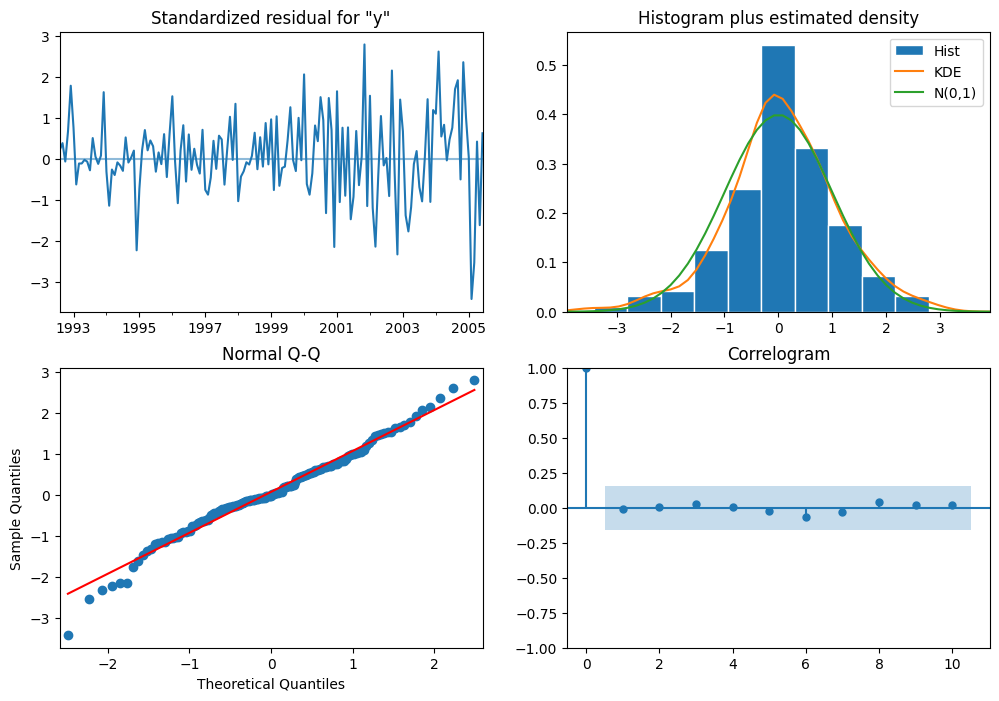

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

SARIMA_model = SARIMAX(train, order=(2, d, 4), seasonal_order=(1, D, 3, s), simple_differencing=False)
SARIMA_model_fit: SARIMAXResults = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(12, 8));

In [80]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_sarimax_resid_pvalues(model_results: SARIMAXResults):
    residuals = model_results.resid
    lb_df = acorr_ljungbox(residuals, np.arange(1, 11))
    lb_df = lb_df.sort_values(by='lb_pvalue', ascending=True)
    return lb_df

get_sarimax_resid_pvalues(SARIMA_model_fit)

,lb_stat,lb_pvalue
1,0.528102,0.467406
7,6.235583,0.512527
8,6.661163,0.573592
9,6.674732,0.670943
2,0.687590,0.709074
10,6.800914,0.744097
3,1.110310,0.774586
4,1.261112,0.867938
5,1.575191,0.904233
6,1.616588,0.951377


In [105]:
from typing import Literal
from statsmodels.tsa.statespace.mlemodel import PredictionResults

def rolling_forecast(
    data: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: Literal['SARIMA', 'last_season'],
) -> tuple[np.ndarray, np.ndarray]: # (realdpi, realcons)
    assert len(data) == train_len + horizon
    pred = np.empty(horizon)
    if method == 'SARIMA':
        for i in range(0, horizon, window):
            model = SARIMAX(data[:train_len+i], 
                            order=(2, d, 4), seasonal_order=(1, D, 3, s), 
                            simple_differencing=False)
            res: SARIMAXResults = model.fit(disp=False)
            predictions: PredictionResults = res.get_prediction(0, train_len+i+window-1)
            oos_pred: pd.DataFrame = predictions.predicted_mean.iloc[-window:]
            pred[i:i+window] = oos_pred.values
        return pred
    elif method == 'last_season':
        for i in range(0, horizon, window):
            last_season = data.iloc[train_len+i-window:train_len+i]
            pred[i:i+window] = last_season.values.squeeze()
        return pred

In [88]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12

SARIMA_pred = rolling_forecast(data, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

In [106]:
SARIMA_last = rolling_forecast(data, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

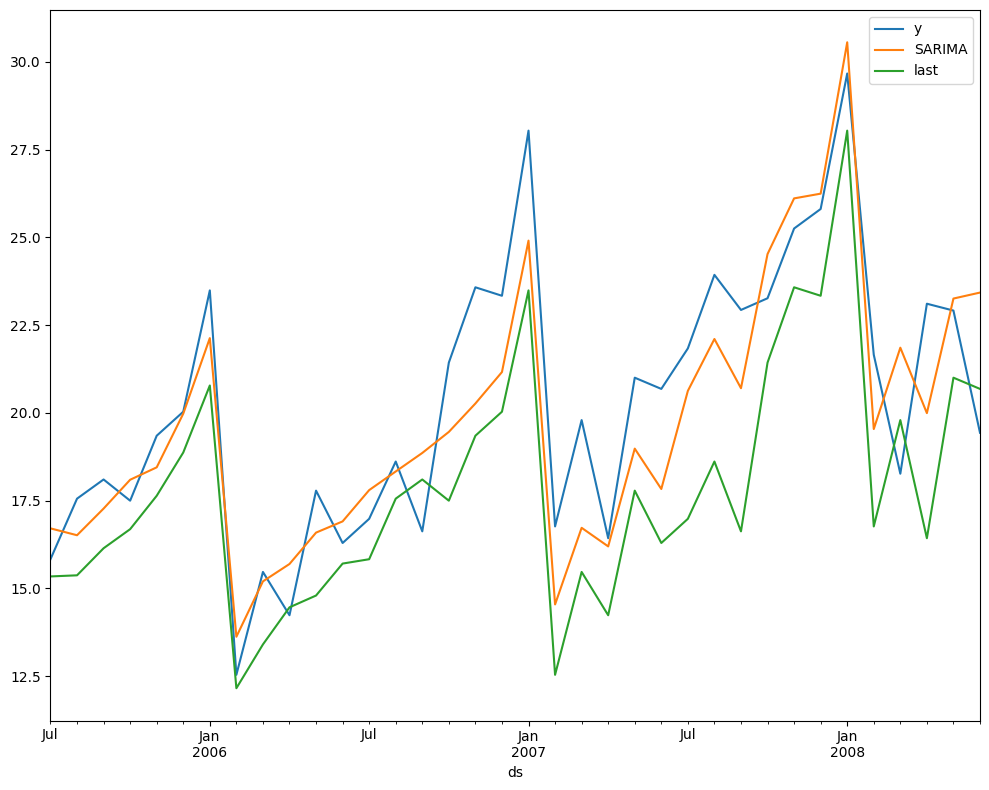

In [107]:
forecast = data.iloc[TRAIN_LEN:]
forecast = forecast.assign(SARIMA=SARIMA_pred, last=SARIMA_last)
forecast.plot(figsize=(10, 8))
plt.tight_layout()

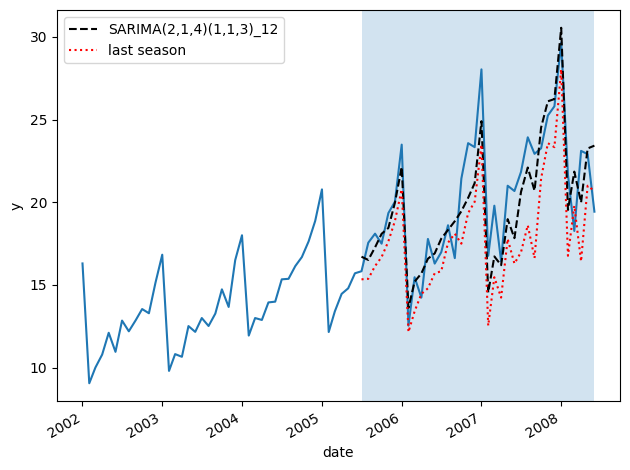

In [119]:
fig, ax = plt.subplots()
ax: Axes

START = 120

raw = data.loc['2002':]
ax.plot(raw.index, raw['y'])
ax.set_xlabel('date')
ax.set_ylabel('y')
ax.axvspan(data.index[TRAIN_LEN], data.index[-1], alpha=.2)
ax.plot(forecast.index, forecast['SARIMA'], 'k--', label='SARIMA(2,1,4)(1,1,3)_12')
ax.plot(forecast.index, forecast['last'], 'r:', label='last season')
ax.legend(loc=2)

fig.autofmt_xdate()
fig.tight_layout()

In [124]:
from sklearn.metrics import mean_absolute_percentage_error

mape_SARIMA = mean_absolute_percentage_error(forecast['y'], forecast['SARIMA'])
print('SARIMA(2,1,4)(1,1,3)_12:', f'{mape_SARIMA*100:.1f}%')

mape_last_season = mean_absolute_percentage_error(forecast['y'], forecast['last'])
print('last season:', f'{mape_last_season*100:.1f}%')

SARIMA(2,1,4)(1,1,3)_12: 7.8%
last season: 12.7%
